# Solar Orbiter Data Aquisition

Based on the sunpy-soar package by Laura Hayes.


Some useful links:

* An introduction to SunPy https://docs.sunpy.org/en/stable/tutorial/index.html
* Solar Orbiter Archive https://soar.esac.esa.int/soar/
* Summary of SOOPs that have been run: https://www.cosmos.esa.int/web/solar-orbiter/soops-summary
* Inventory plots of data on SOAR: https://www.cosmos.esa.int/web/soar/inventory-plots
* STIX data center: https://datacenter.stix.i4ds.net/stix
* EUI/SIDC Solar Eruption list: https://www.sidc.be/EUI/solar-eruptions
* EPD data loader: https://github.com/jgieseler/solo-epd-loader


In [1]:
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import pandas as pd
from sunpy.net import Fido, attrs as a 
from sunpy.coordinates import frames, get_horizons_coord, get_body_heliographic_stonyhurst
from sunpy.time import parse_time
import sunpy.map
import sunpy.timeseries
import sunpy_soar
from astropy import units as u 
from astropy.coordinates import SkyCoord
from astropy.visualization import PowerStretch, AsinhStretch, LogStretch
from astropy.wcs import WCS
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import constants as const
from astropy.time import Time
from reproject.mosaicking import reproject_and_coadd
from reproject import reproject_interp
from pytplot import tplot, get_data, cdf_to_tplot, store_data
import glob
import pyspedas
import datetime
import astrospice
for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 
from scipy.interpolate import interp1d

HTTPError: HTTP Error 404: Not Found

In [ ]:
# check if necessary folders exists
folder_path = os.path.realpath('results')
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")

# Access and download Solar Orbiter data with Sunpy

## Lets construct a query

To search for data with Fido, you need to specify attributes to search with. These are usually a timerange (`a.Time`), and an instrument (`a.Instrument`). But you can also add lots of different attributes to make your query more specific. It should also be noted that Fido will return all possible results given the conditions of your query, so for example, if two data providers host the same data, it will return two results (for example the VSO provides the EUI data as well as the SOAR). You can also specifiy the provider you want to search for in your query.

In [2]:
### TIME RANGE OF INTEREST
timerange = a.Time("2022-02-28", "2022-03-01")

Now we construct a query to specifically search for the instrument, level, and data product that we want.

In [3]:
### SEARCH FOR MAG RTN DATA - L2 MAG
mag_files = Fido.search(timerange, 
                      a.Instrument("MAG"), 
                      a.Level(2), a.Provider.soar, a.soar.Product('mag-rtn-normal-1-minute'))
### SEARCH FOR PAS PARTICLE DATA - L2 SWA
pas_files = Fido.search(timerange, 
                      a.Instrument("SWA"), 
                      a.Level(2), a.Provider.soar, a.soar.Product('swa-pas-grnd-mom'))
### SEARCH FOR HIS DATA - L3 SWA 
his_files = Fido.search(timerange, 
                      a.Instrument("SWA"), 
                      a.Level(3), a.Provider.soar, a.soar.Product('swa-his-comp-10min'))

### Then to download the files, you can use `Fido.fetch`

Now that we have located the files were interested in via a `Fido.search`, we can download them via `Fido.fetch`.
You pass your query results from `Fido.search` to the `.fetch`. You can also specifiy the path for which to save them locally. Here we save them in the same structure as pySPEDAS.

In [4]:
### DOWNLOAD MAG DATA
mag = Fido.fetch(mag_files, path="./solar_orbiter_data/mag/L2/2022")

### DOWNLOAD PAS DATA
pas = Fido.fetch(pas_files, path="./solar_orbiter_data/swa/L2/2022")

### DOWNLOAD HIS DATA
his = Fido.fetch(his_files, path="./solar_orbiter_data/swa/L3/2022")

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

solo_L2_mag-rtn-normal-1-minute_20220228_V02.cdf:   0%|          | 0.00/32.5k [00:00<?, ?B/s]

solo_L2_mag-rtn-normal-1-minute_20220301_V02.cdf:   0%|          | 0.00/32.6k [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

solo_L2_swa-pas-grnd-mom_20220301_V02.cdf:   0%|          | 0.00/2.70M [00:00<?, ?B/s]

solo_L2_swa-pas-grnd-mom_20220228_V02.cdf:   0%|          | 0.00/2.70M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

solo_L3_swa-his-comp-10min_20220228_V02.cdf:   0%|          | 0.00/268k [00:00<?, ?B/s]

solo_L3_swa-his-comp-10min_20220301_V02.cdf:   0%|          | 0.00/269k [00:00<?, ?B/s]

Lets load in situ data into a sunpy [`TimeSeries`](https://docs.sunpy.org/en/stable/tutorial/timeseries.html) and concatenate the files

In [5]:
### CREATE MAG TIMESERIES
mag_data = sunpy.timeseries.TimeSeries(mag, concatenate=True)

### CREATE MAG TIMESERIES
pas_data = sunpy.timeseries.TimeSeries(pas, concatenate=True)

### CREATE MAG TIMESERIES
his_data = sunpy.timeseries.TimeSeries(his, concatenate=True)

29-Aug-25 18:57:09: /Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/sunpy/io/_cdf.py:98: SunpyUserWarning: astropy did not recognize units of "Ticks". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
  warn_user(f'astropy did not recognize units of "{unit_str}". '

29-Aug-25 18:57:09: /Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/sunpy/io/_cdf.py:98: SunpyUserWarning: astropy did not recognize units of "Ticks". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
  warn_user(f'astropy did not recognize units of "{unit_str}". '



An example of plotting the data using the Sunpy ecosystem! This is an easy way to get a quicklook at the data.

Text(0.5, 1.0, '$\\rm Solar \\; Orbiter \\; Overview$')

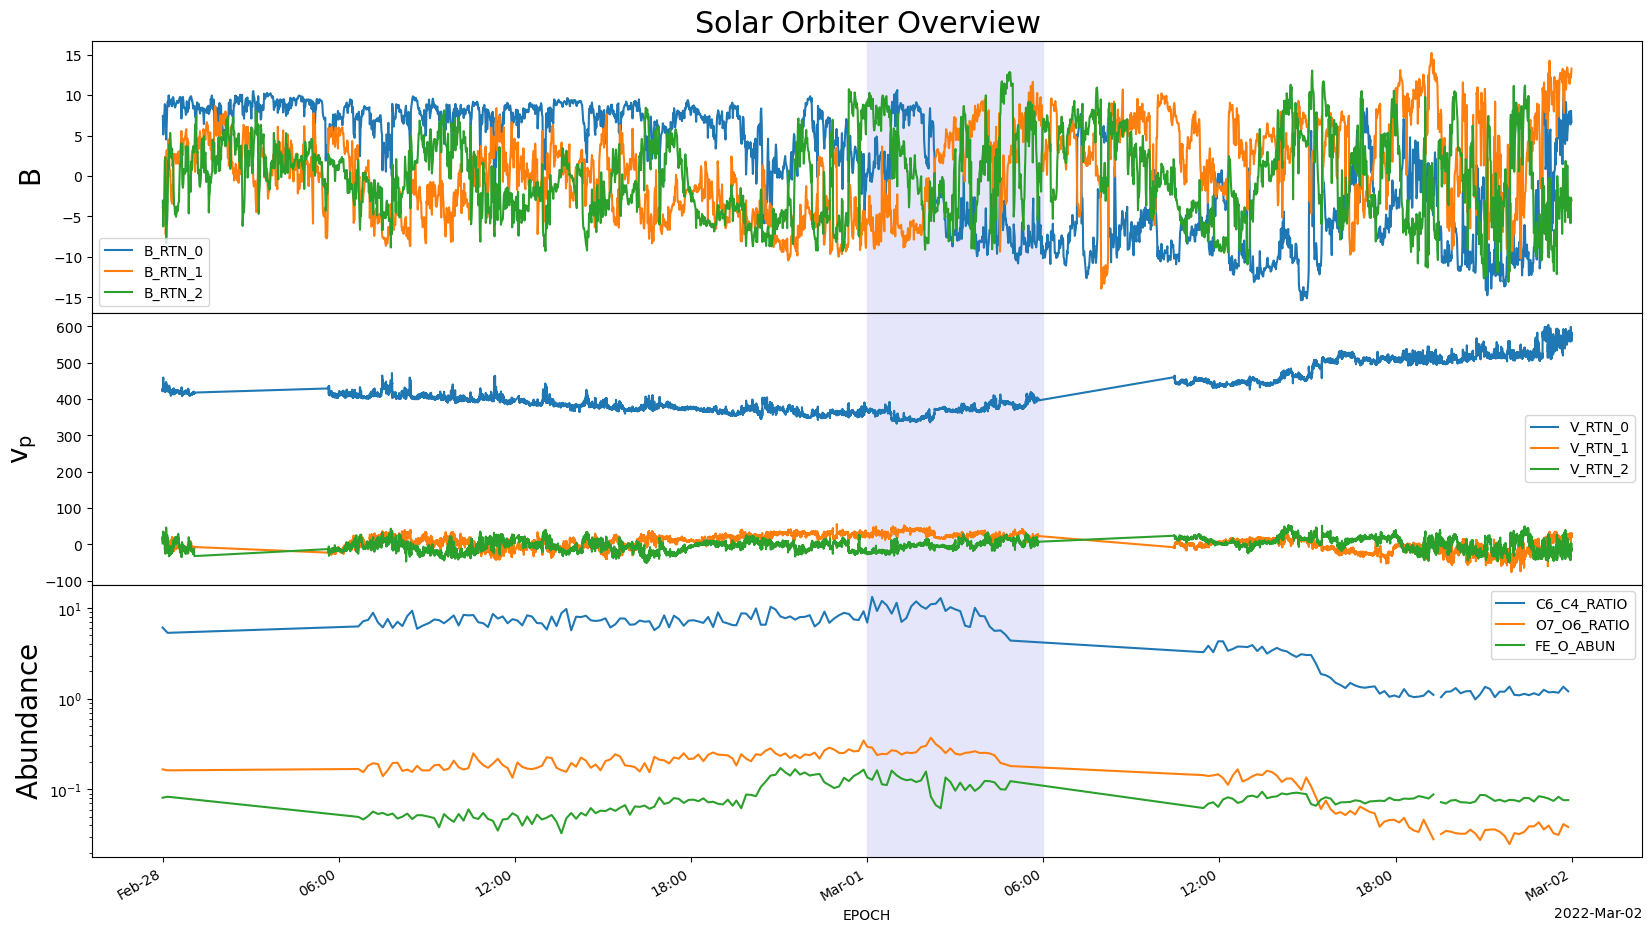

In [6]:
### OVERVIEW OF DATA
ylabels=[r'$\rm B$', r'$\rm v_p$', r'$\rm Abundance$']
fig, axs = plt.subplots(3, figsize=[20, 12], sharex='all', gridspec_kw={'hspace':0})
mag_data.plot(columns=["B_RTN_0", "B_RTN_1", "B_RTN_2"], axes=axs[0])
pas_data.plot(columns=["V_RTN_0", "V_RTN_1", "V_RTN_2"], axes=axs[1])
his_data.plot(columns=["C6_C4_RATIO", "O7_O6_RATIO", "FE_O_ABUN"], axes=axs[2])
axs[2].set_yscale('log')
for i, ax in enumerate(axs):
    ax.set_ylabel(ylabels[i], fontsize=20)
    ax.axvspan(pd.Timestamp('03/01/2022 00:00:00'), pd.Timestamp('03/01/2022 6:00:00'), zorder=-2, color='lavender')
axs[0].set_title(r'$\rm Solar \; Orbiter \; Overview$', fontsize=22)

# Create Orbiter MAG/SWA Dataframe

We will create a pandas dataframe for each instrument, this is easier to use for plotting/science purposes. We then use pandas to merge the dataframes as a function of time.



In [9]:
### SOLO MAG DATA
mm = mag_data.to_dataframe()
rd = {'Time': mm.index, 'Br': mm.B_RTN_0, 'Bt': mm.B_RTN_1, 'Bn': mm.B_RTN_2}
mag = pd.DataFrame(data=rd, index=None)
mag.to_csv(os.path.join('results', 'mag.csv'))

In [16]:
### SOLO SWA/PAS DATA
mm = pas_data.to_dataframe()
rd = {'Time': mm.index, 'vr': mm.V_RTN_0, 'vt': mm.V_RTN_1, 'vn': mm.V_RTN_2, 'Np': mm.N, 'Tp': mm['T']}
pas = pd.DataFrame(data=rd)
pas.to_csv(os.path.join('results', 'pas.csv'))

In [17]:
### SOLO SWA/HIS DATA
mm = his_data.to_dataframe()
rd = {'Time': mm.index, 'FeO': mm.FE_O_ABUN, 'C6C4': mm.C6_C4_RATIO, 'O7O6': mm.O7_O6_RATIO}
his = pd.DataFrame(data=rd)
his.to_csv(os.path.join('results', 'his.csv'))

Now that we have a dataframe for each instrument, we will merge these dataframes as a function of time. 
WARNING!!! The cadence of SWA/HIS measurements is much less than the MAG & SWA/PAS cadence. If you decide to incorporate HIS measurements, you should create separate dataframes so you can study different timescales of fluctuations.

In [21]:
### merge the PAS and MAG dataframes
merged_df = pd.merge_asof(pas, mag, on='Time', direction='backward')

### merge the HIS and newly merged dataframe
merged_df = pd.merge_asof(his, merged_df, on='Time', direction='backward')
merged_df = merged_df.set_index('Time')

## Find the spacecraft trajectory

Now we will use astrospice to generate the trajectory of the spacecraft. We transform from inertial coordinates to the solar co-rotating (Carrington) frame!

In [22]:
### Create SkyCoord for Orbiter in the inertial (J2000) frame
solo_inertial = astrospice.generate_coords(
    'SOLAR ORBITER', pd.to_datetime(merged_df.index.to_list())

)

### Transform to solar co-rotating frame 
solo_carrington = solo_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

Now we will add the position information to our merged dataframe and save as a CSV file!

In [23]:
### ADD POSITION INFORMAITON AND SAVE
orbiter = merged_df.copy()
orbiter['lon'] = solo_carrington.lon.value
orbiter['lat'] = solo_carrington.lat.value
orbiter['rAU'] = solo_carrington.radius.to(u.AU).value
orbiter['NpR2'] = orbiter.Np * (orbiter.rAU ** 2)
orbiter['BrR2'] = orbiter.Br * (orbiter.rAU ** 2)
orbiter.to_csv(os.path.join('results', 'orbiter.csv'))
orbiter

,FeO,C6C4,O7O6,vr,vt,vn,Np,Tp,Br,Bt,Bn,lon,lat,rAU,NpR2,BrR2
Time,,,,,,,,,,,,,,,,
2022-02-28 00:00:06.789,0.124352,4.666133,0.155761,424.744781,19.354290,9.476597,15.910052,14.443886,NaN,NaN,NaN,88.846704,-3.953242,0.588543,5.510963,NaN
2022-02-28 00:10:06.790,0.143489,4.374543,0.132367,430.309509,-10.409559,4.992716,15.175641,13.325876,8.347488,0.860707,-5.480343,88.762049,-3.953671,0.588459,5.255083,2.890602
2022-02-28 06:40:08.304,0.087948,5.567347,0.157014,403.868774,-2.350639,-11.650457,14.210595,12.659678,7.465621,2.410246,1.980348,85.463394,-3.970309,0.585193,4.866437,2.556611
2022-02-28 06:50:08.308,0.096935,5.883932,0.116356,404.171631,9.492729,-8.537971,14.608211,12.434838,7.570980,-3.244457,0.379171,85.378898,-3.970733,0.585110,5.001167,2.591949
2022-02-28 07:00:08.307,0.088331,5.510294,0.152262,405.851929,-1.856772,-0.798619,14.604689,13.610792,8.389572,1.017700,-0.502235,85.294407,-3.971157,0.585026,4.998528,2.871373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-03 23:12:35.832,0.177951,0.806852,0.030863,534.060486,-52.871349,-16.808073,12.657435,43.209732,-7.727091,-2.800273,-14.610142,41.199120,-4.174650,0.539771,3.687772,-2.251305
2022-03-03 23:22:35.834,0.186515,1.020882,0.043776,553.383423,-22.988846,-29.223343,12.831614,45.184616,-4.232800,8.969854,-11.212367,41.117091,-4.174984,0.539684,3.737315,-1.232838
2022-03-03 23:32:35.837,0.199694,1.263365,0.042423,512.782776,-59.263123,-24.667286,11.267587,40.657085,-9.783181,-2.474164,-11.849442,41.035067,-4.175318,0.539597,3.280721,-2.848515
